# Lab2 - AI - Convolutional Neural networks for image recognition

**R4.A.13 - BUT2 - IUT Vannes**


## Introduction

In this lab, we will first build and train a convolutional neural network (CNN) for digit recognition from the MNIST dataset. Results will be compared with those obtained by neural networks in Lab1.

In the second part, we build and train CNNs for color object detection from the CIFAR10 dataset.

This lab was prepared based on the tutorials: (https://datahacker.rs/005-pytorch-convolutional-neural-network-on-mnist-in-pytorch/) and (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

Please note that the implementations from these tutorials need to be adapted and corrected. A simple copy/paste will not work.


**Setting up the environment**


In [3]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [4]:
# what is your GPU ?
!nvidia-smi


'nvidia-smi' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


## PART 1: CNNs for digit recognition from MNIST dataset

### **1. Loading MNIST dataset from torchvision**

In [40]:
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

# Download and load the training data and the validation (test) data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)


In [41]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))


Train size :  60000
validation size :  10000


In [42]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels


torch.Size([64, 1, 28, 28])
torch.Size([64])


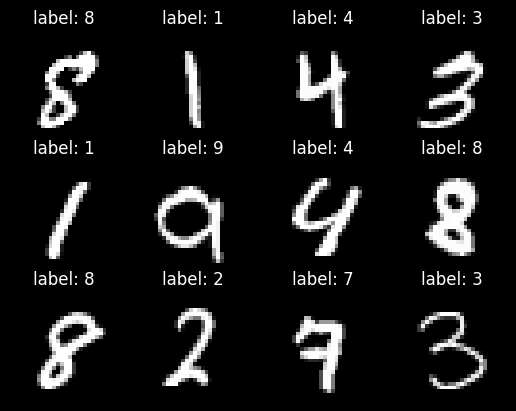

In [43]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray'); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))


### **2. Build a convolutional neural network**

Let's define a **convolutional neural network** with 2 conv layers and 1 fc layer
- first conv layer: 32 filters of size $5\times 5$, stride 1, padding 2
- maxpooling layer: size 2
- second conv layer: 64 filters of size $5\times 5$, stride 1, padding 2
- maxpooling layer: size 2
- fully-connected layer with 128 neurons
- activation ReLu (after each conv layer and the fc layer)
- do not use *dropout* layer (as proposed in the tutorial) for the moment

In [44]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64*7*7, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64*7*7)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


Let's now initialize the network

In [45]:
model = CNN()
model.to(device)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

**---------------Question 1---------------**

*   Calcuate the output size of feature maps after each layer of the network.
*   Calculate also the total number of parameters of the network
*   Print the total number of trainable parameters in Pytorch ?

In [46]:
# Calcuate the output size of feature maps after each layer of the network.
output = model(images.to(device))
print(output.shape)

# Calculate also the total number of parameters of the network
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} total trainable parameters.')


torch.Size([64, 10])
421,642 total parameters.
421,642 total trainable parameters.


### **3. Train the model**

Let's set up the optimizer and the loss function. You can use the Stochastic Gradient Descent optimizer (SGD) and the Cross-entropy loss as proposed by the tutorial.

In [47]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


Now train and evaluate/validate the model (during the training)

In [48]:
def train(model, trainLoader, criterion, optimizer):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0
  train_losses = []
  train_accuracies = []
  for batch_idx, (data, target) in enumerate(trainLoader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().item()
    if batch_idx % 100 == 0:
      print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      train_losses.append(train_loss / (batch_idx + 1))
      train_accuracies.append(100. * correct / total)
  return train_losses, train_accuracies

print("Training the model...")
train_losses, train_accuracies = train(model, trainLoader, criterion, optimizer)

def validate(model, validationLoader, criterion):
  model.eval()
  validation_loss = 0.0
  correct = 0
  total = 0
  val_losses = []
  val_accuracies = []
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(validationLoader):
      data, target = data.to(device), target.to(device)
      outputs = model(data)
      loss = criterion(outputs, target)
      validation_loss += loss.item()
      _, predicted = outputs.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()
      if batch_idx % 20 == 0:
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (validation_loss/(batch_idx+1), 100.*correct/total, correct, total))
        val_losses.append(validation_loss / (batch_idx + 1))
        val_accuracies.append(100. * correct / total)
  return val_losses, val_accuracies

print("Validating the model...")
val_losses, val_accuracies = validate(model, validationLoader, criterion)


Training the model...
Loss: 2.324 | Acc: 6.250% (4/64)
Loss: 0.645 | Acc: 79.270% (5124/6464)
Loss: 0.422 | Acc: 86.707% (11154/12864)
Loss: 0.328 | Acc: 89.685% (17277/19264)
Loss: 0.276 | Acc: 91.338% (23441/25664)
Loss: 0.244 | Acc: 92.303% (29596/32064)
Loss: 0.219 | Acc: 93.074% (35800/38464)
Loss: 0.200 | Acc: 93.705% (42040/44864)
Loss: 0.186 | Acc: 94.173% (48277/51264)
Loss: 0.173 | Acc: 94.556% (54525/57664)
Validating the model...
Loss: 0.048 | Acc: 98.438% (63/64)
Loss: 0.028 | Acc: 98.884% (1329/1344)
Loss: 0.035 | Acc: 98.895% (2595/2624)
Loss: 0.042 | Acc: 98.694% (3853/3904)
Loss: 0.038 | Acc: 98.843% (5124/5184)
Loss: 0.041 | Acc: 98.778% (6385/6464)
Loss: 0.040 | Acc: 98.760% (7648/7744)
Loss: 0.040 | Acc: 98.781% (8914/9024)


Let’s plot our loss and accuracies and see if they are falling or growing.



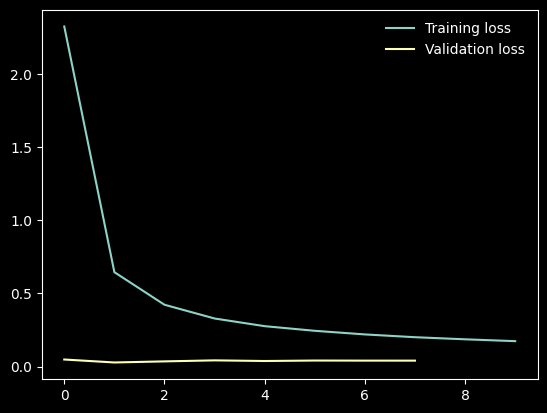

In [49]:
# plot the loss curves
def plot_loss(train_loss, val_loss):
  plt.plot(train_loss, label='Training loss')
  plt.plot(val_loss, label='Validation loss')
  plt.legend(frameon=False)
  plt.show()

plot_loss(train_losses, val_losses)


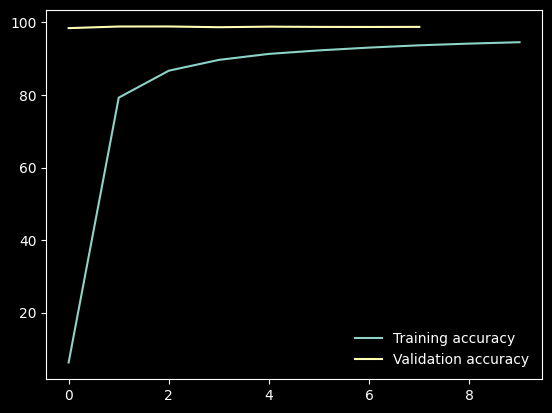

In [50]:
# plot the accuracy curves
def plot_accuracy(train_accuracy, val_accuracy):
  plt.plot(train_accuracy, label='Training accuracy')
  plt.plot(val_accuracy, label='Validation accuracy')
  plt.legend(frameon=False)
  plt.show()

plot_accuracy(train_accuracies, val_accuracies)


**---------------Question 2---------------**

*  Your remarks and comments about the training process compared to the neural networks in Lab1 ?
*  How could we improve the performance ?  
We could use a dropout layer, increase the number of epochs, use a different optimizer, etc.

### **4. Evaluation a trained network**

Once our model is trained, we can simply use the trained weights to make some new predictions by turning off the gradients.

Let's first predict label for a single image.

Predicted label: 8
True label: 8


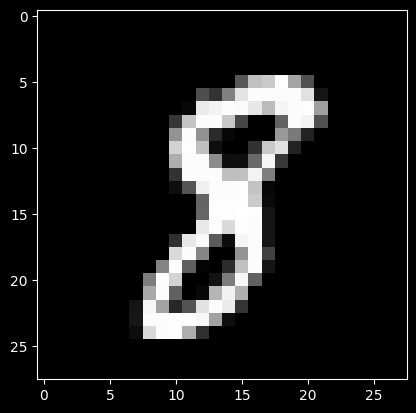

In [57]:
# predict label for a single image
def predict(model, test_image):
  model.eval()
  with torch.no_grad():
    output = model(test_image)
    _, predicted = output.max(1)
    return predicted.item()

# Display the image and the prediction
test_image, test_label = next(iter(validationLoader))
idx = 0
plt.imshow(test_image[idx].numpy().squeeze(), cmap='gray')
print(f"Predicted label: {predict(model, test_image[idx].to(device))}")
print(f"True label: {test_label[idx].item()}")
plt.show()


Predict labels for a batch

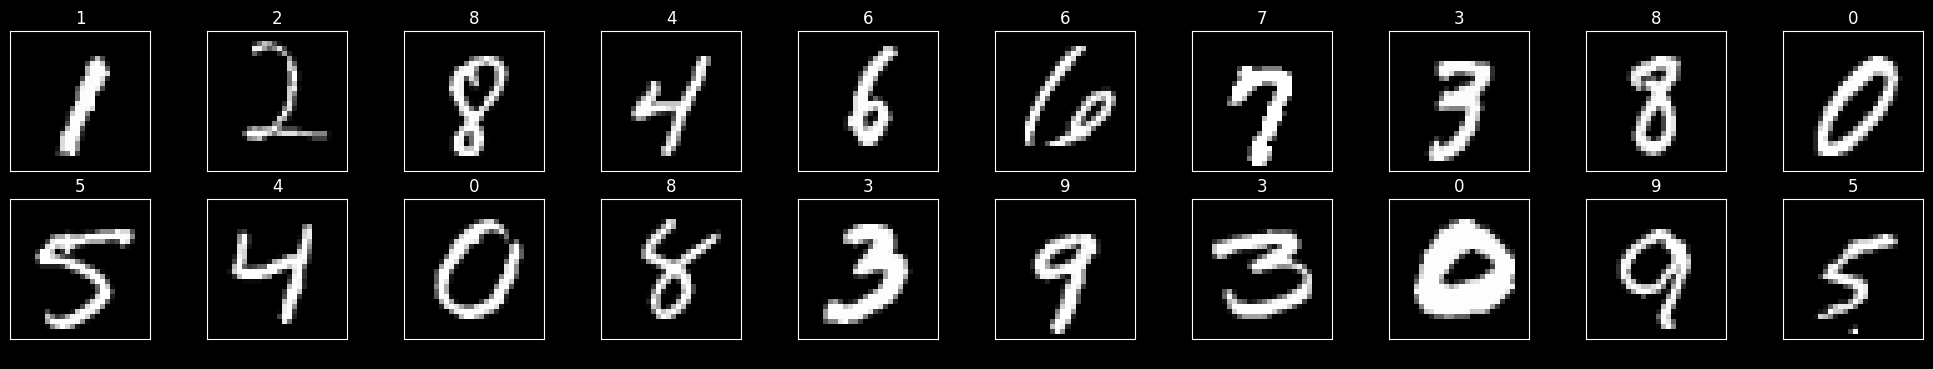

In [58]:
# predict label for a batch of images
def predict_batch(model, test_loader):
  model.eval()
  with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, predicted = output.max(1)
    return data, predicted, target

# Display the image and the prediction
data, predicted, target = predict_batch(model, validationLoader)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray')
  true_label = target[idx].item()
  ax.set_title(f'{predicted[idx].item()}', color="white" if predicted[idx].item() == true_label else "red")
  ax.set_xlabel(true_label, color="black")
plt.show()


Calculate the performance on the whole validation set

In [59]:
# calculate the performance of the whole validation set
def evaluate(model, validationLoader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for data in validationLoader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

accuracy = evaluate(model, validationLoader)
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')


Accuracy of the network on the 10000 test images: 98.76 %


### **5. Building other CNNs**
You can also create and test other CNNs by changing the number of filters, adding more layers, etc.

Report the performance and comments on your work
  

In [19]:
# your work


In [20]:
# your work


In [21]:
# your work


## PART 2: CNNs for color object recognition from CIFAR10 dataset

Now let's build CNN models to work on the CIFAR10 dataset.

Try to reach the best performance on validation by designing other CNNs.

In [60]:
# Define transform to normalize data

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data and the validation (test) data
cifar_train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=cifar_transform)
cifar_trainLoader = torch.utils.data.DataLoader(cifar_train_set, batch_size=64, shuffle=True)

cifar_validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=cifar_transform)
cifar_validationLoader = torch.utils.data.DataLoader(cifar_validation_set, batch_size=64, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [61]:
# show the training size, test size, number of class
print("Train size : ", len(cifar_train_set))
print("validation size : ", len(cifar_validation_set))


Train size :  50000
validation size :  10000


In [63]:
# check the size of the image tensors and label tensors
cifar_training_data = enumerate(cifar_trainLoader)
cifar_batch_idx, (cifar_images, cifar_labels) = next(cifar_training_data)

print(cifar_images.shape) # the size of the image
print(cifar_labels.shape) # the size of the labels


torch.Size([64, 3, 32, 32])
torch.Size([64])


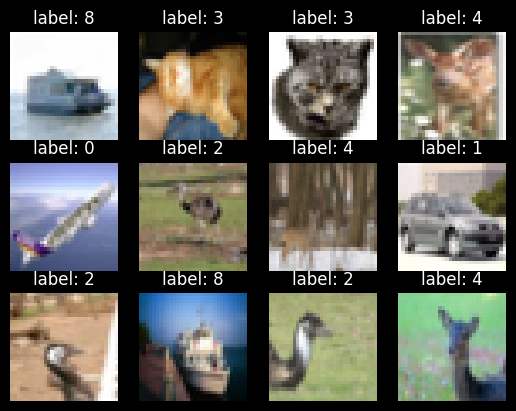

In [64]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((cifar_images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off') # (img/2+0.5) is just to unnormalize the image
    plt.title("label: " + str(cifar_labels[i].numpy().squeeze()))


In [65]:
# build the CNN

class CifarCNN(nn.Module):
  def __init__(self):
    super(CifarCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64*8*8, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64*8*8)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

cifar_model = CifarCNN()
cifar_model.to(device)


CifarCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [66]:
# Calcuate the output size of feature maps after each layer of the network.
cifar_output = cifar_model(cifar_images.to(device))
print(cifar_output.shape)

# Calculate also the total number of parameters of the network
ci_total_params = sum(p.numel() for p in cifar_model.parameters())
print(f'{ci_total_params:,} total parameters.')

# Print the total number of trainable parameters in Pytorch ?
ci_total_trainable_params = sum(p.numel() for p in cifar_model.parameters() if p.requires_grad)
print(f'{ci_total_trainable_params:,} total trainable parameters.')


torch.Size([64, 10])
545,098 total parameters.
545,098 total trainable parameters.


In [67]:
ci_optimizer = optim.SGD(cifar_model.parameters(), lr=0.001, momentum=0.9)
ci_criterion = nn.CrossEntropyLoss()


In [68]:
def ci_train(model, trainLoader, criterion, optimizer):
  model.train()
  train_loss = 0.0
  correct = 0
  total = 0
  train_losses = []
  train_accuracies = []
  for batch_idx, (data, target) in enumerate(trainLoader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    _, predicted = outputs.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().item()
    if batch_idx % 100 == 0:
      print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      train_losses.append(train_loss / (batch_idx + 1))
      train_accuracies.append(100. * correct / total)
  return train_losses, train_accuracies

print("Training the model...")
ci_train_losses, ci_train_accuracies = ci_train(cifar_model, cifar_trainLoader, ci_criterion, ci_optimizer)

def ci_validate(model, validationLoader, criterion):
  model.eval()
  validation_loss = 0.0
  correct = 0
  total = 0
  val_losses = []
  val_accuracies = []
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(validationLoader):
      data, target = data.to(device), target.to(device)
      outputs = model(data)
      loss = criterion(outputs, target)
      validation_loss += loss.item()
      _, predicted = outputs.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()
      if batch_idx % 20 == 0:
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (validation_loss/(batch_idx+1), 100.*correct/total, correct, total))
        val_losses.append(validation_loss / (batch_idx + 1))
        val_accuracies.append(100. * correct / total)
  return val_losses, val_accuracies

print("Validating the model...")
ci_val_losses, ci_val_accuracies = ci_validate(cifar_model, cifar_validationLoader, ci_criterion)


Training the model...
Loss: 2.302 | Acc: 9.375% (6/64)
Loss: 2.292 | Acc: 13.041% (843/6464)
Loss: 2.271 | Acc: 16.091% (2070/12864)
Loss: 2.235 | Acc: 18.646% (3592/19264)
Loss: 2.198 | Acc: 20.277% (5204/25664)
Loss: 2.164 | Acc: 21.732% (6968/32064)
Loss: 2.133 | Acc: 23.126% (8895/38464)
Loss: 2.101 | Acc: 24.403% (10948/44864)
Validating the model...
Loss: 1.822 | Acc: 35.938% (23/64)
Loss: 1.812 | Acc: 37.500% (504/1344)
Loss: 1.827 | Acc: 35.709% (937/2624)
Loss: 1.829 | Acc: 35.758% (1396/3904)
Loss: 1.835 | Acc: 35.783% (1855/5184)
Loss: 1.829 | Acc: 36.061% (2331/6464)
Loss: 1.834 | Acc: 36.080% (2794/7744)
Loss: 1.830 | Acc: 36.093% (3257/9024)


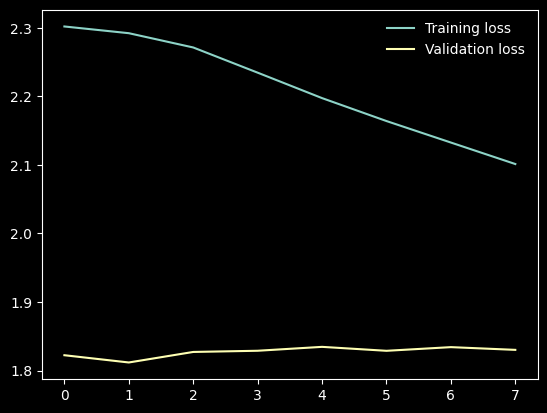

In [69]:
# plot the loss curves
def ci_plot_loss(train_loss, val_loss):
  plt.plot(train_loss, label='Training loss')
  plt.plot(val_loss, label='Validation loss')
  plt.legend(frameon=False)
  plt.show()

ci_plot_loss(ci_train_losses, ci_val_losses)


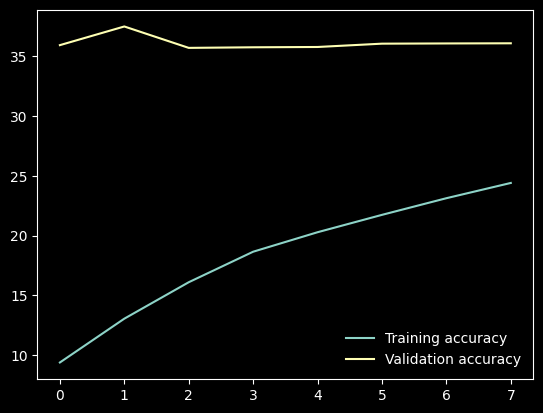

In [70]:
# plot the accuracy curves
def ci_plot_accuracy(train_accuracy, val_accuracy):
  plt.plot(train_accuracy, label='Training accuracy')
  plt.plot(val_accuracy, label='Validation accuracy')
  plt.legend(frameon=False)
  plt.show()

ci_plot_accuracy(ci_train_accuracies, ci_val_accuracies)


Predicted label: 6
True label: 6


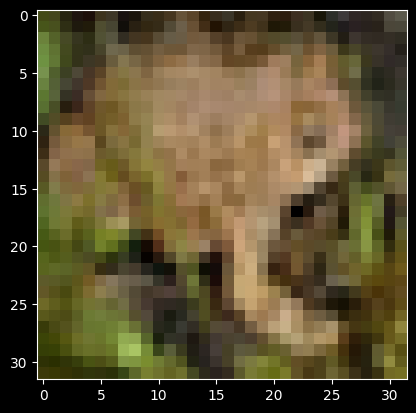

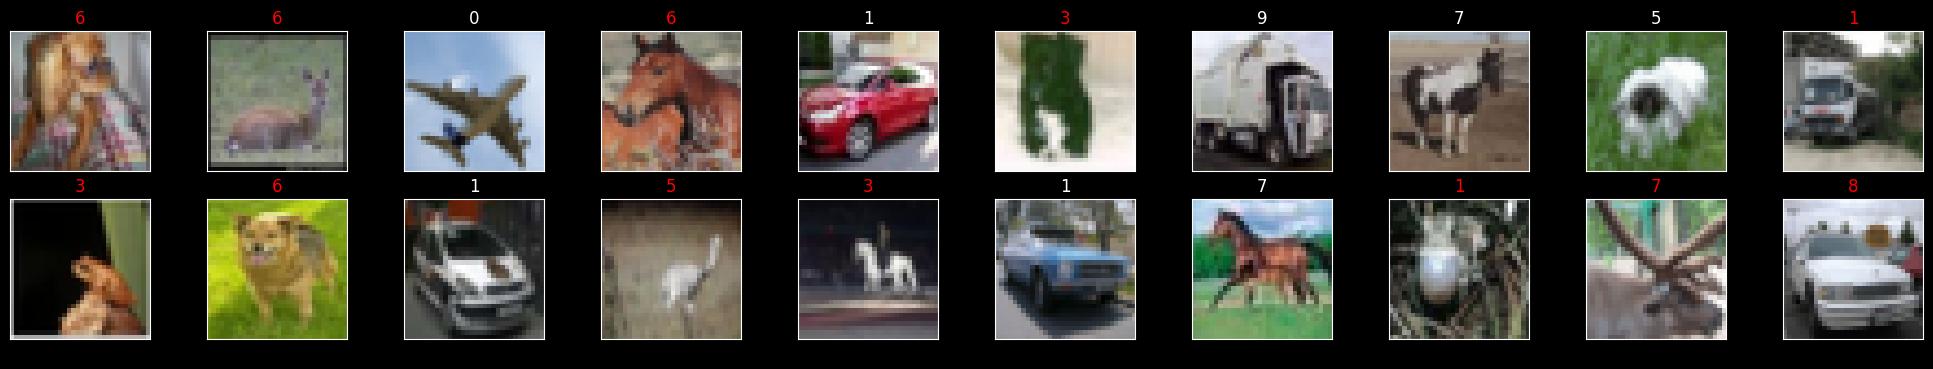

Accuracy of the network on the 10000 test images: 36.18 %


In [71]:
def ci_predict(model, test_image):
  model.eval()
  with torch.no_grad():
    output = model(test_image)
    _, predicted = output.max(1)
    return predicted.item()
  
# Display the image and the prediction
ci_test_image, ci_test_label = next(iter(cifar_validationLoader))
idx = 0
plt.imshow((ci_test_image[idx]/ 2 + 0.5).permute(1,2,0).numpy())
print(f"Predicted label: {ci_predict(cifar_model, ci_test_image[idx].to(device))}")
print(f"True label: {ci_test_label[idx].item()}")
plt.show()

def ci_predict_batch(model, test_loader):
  model.eval()
  with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    _, predicted = output.max(1)
    return data, predicted, target
  
# Display the image and the prediction
data, predicted, target = ci_predict_batch(cifar_model, cifar_validationLoader)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  ax.imshow((data[idx]/ 2 + 0.5).permute(1,2,0).numpy())
  true_label = target[idx].item()
  ax.set_title(f'{predicted[idx].item()}', color="white" if predicted[idx].item() == true_label else "red")
  ax.set_xlabel(true_label, color="black")
plt.show()

def ci_evaluate(model, validationLoader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for data in validationLoader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

ci_accuracy = ci_evaluate(cifar_model, cifar_validationLoader)
print(f'Accuracy of the network on the 10000 test images: {ci_accuracy:.2f} %')


**---------------Question 3---------------**

*  Your remarks and comments about the training process and the performance of CNN on Cifar10 ?
*  How could we improve the performance ?